# Content-Based Recommender Systems

## Introduction

Content-Based Recommendation systems use item features to recommend other similar items to users based on what they like, their previous actions, or explicit feedback. In this tutorial, we specifically focus on the retrieval or candidate generation stage of recommender systems in which the initial set of candidates is selected out of all the possible candidates. 



Retrieval models often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features

The outputs of the two models are then multiplied together to give us a query-candidate affinity score - the higher the score, the better the match between the candidate and the query. The dot product of a user, item pair that actually interacted is high and the dot product of a non-interacting pair is close to 0.

The following notebook implements this two-tower model using [Tensorflow Recommenders](https://www.tensorflow.org/recommenders).

![](https://miro.medium.com/max/1400/0*bii7baVk5nF6lulx)



## The Dataset

The Movielens dataset is a popular dataset from the [GroupLens](https://grouplens.org/datasets/movielens/) research group at the University of Minnesota. It contains a set of ratings given to movies by a set of users, and is often used for recommender system research.

In this demo, the data will be treated as an implicit feedback: expressesing which movies the users watched (and rated), and which they did not. Thus, a users' watches gives information about which things they prefer to see and which they'd rather not see. Every movie a user has watched is a positive example and every movie they have not seen is a negative example.

This model predicts a set of movies from the catalogue that the user is likely to watch. 

## Imports

In [1]:
from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

2022-08-18 16:33:06.502493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/python-3.7.9/lib
2022-08-18 16:33:06.502529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading the Data

We load the MovieLens dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets). Loading `movielens/100k_ratings` yields a `tf.data.Dataset` object containing the ratings data and loading `movielens/100k_movies` yields a `tf.data.Dataset` object containing only the movies data.

<!-- the MovieLens dataset does not have predefined splits, all data are under `train` split. -->

In [2]:
# Ratings
ratings = tfds.load("movielens/100k-ratings", split="train")
# Features of movies
movies = tfds.load("movielens/100k-movies", split="train")

2022-08-18 16:33:10.419290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/python-3.7.9/lib
2022-08-18 16:33:10.419384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/python-3.7.9/lib
2022-08-18 16:33:10.419444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/python-3.7.9/lib
2022-08-18 16:33:10.419503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object

The ratings dataset returns a dictionary of movie id, user id, rating, timestamp, movie information, and user information.

In [3]:
ratings_data = []
for x in ratings.take(5).as_numpy_iterator():
  ratings_data.append(x)

pd.DataFrame.from_dict(ratings_data)

2022-08-18 16:33:10.598634: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


The movies dataset contains the movie id, movie title, and data on what genres it belongs to.

In [4]:
movies_data = []
for x in movies.take(5).as_numpy_iterator():
  movies_data.append(x)


pd.DataFrame.from_dict(movies_data)

2022-08-18 16:33:10.662989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,"[4, 7]",b'1457',b'Love Is All There Is (1996)'
2,"[1, 3]",b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"


In this example, we will explore the `user_id`, `timestamp`, and `movie_title` fields in the dataset.

In [5]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})
movies = movies.map(lambda x: x["movie_title"])

The `user_id` and `movie_title` features are categorical and we need to map them to embedding vectors in order to use them in a deep learning model. Our goal is to predict which user is going to watch which movie. To do that, we represent each user and each movie by an embedding vector. Initially, these embeddings will take on random values - but during training, we will adjust them so that embeddings of users and the movies they watch end up closer together.

To turn the raw categorical features into embeddings, we must first translate the values into a range of continuous integers, also known as a mapping or vocabulary. For example, we map the value "Star Wars" to 15. Then, we need to convert these integers into embeddings.

The `timestamp` feature is continuous and can be discretized into a number of categorical features. Here, we establish the boundaries of the buckets we use for discretization by identifying the minimum and maximum value of the feature, and divide the resulting interval equally. The bucket boundaries can then be transformed into embeddings.

In [6]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

## Model Definition

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

### The Query Tower

We start by defining the UserModel which will convert the raw input to feature embeddings using `Embedding` layers.

An embedding layer has two dimensions: the first dimension tells us how many distinct categories we can embed; the second tells us how large the vector representing each of them can be.




In [7]:
class UserModel(tf.keras.Model):
  
  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    if not self._use_timestamps:
      return self.user_embedding(inputs["user_id"])

    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

### The Candidate Tower

We can do the same with the movie tower.

In this case, our `movie_title` feature is text, so the first transformations we should apply is tokenization and create a vocabulary of these tokens. The `tf.keras.layers.TextVectorization` layer from Keras performs both these steps. To embed the text, we can average all of the words' embeddings to get a single embedding.

In [8]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

### The Full Model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines building models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

### Metrics

In our training data we have positive (user, movie) pairs. We need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates. If the score for the positive pair is higher than for all other candidates, our model is highly accurate.

We use the `tfrs.metrics.FactorizedTopK` which has one required argument: the dataset of candidates that are used as implicit negatives for evaluation. In this case, that's the `movies` dataset, converted into embeddings via our movie model. This metric measures how good the model is at picking the true candidate out of all possible candidates in the system.

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [9]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      MovieModel(),
      tf.keras.layers.Dense(32)
    ])
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(query_embeddings, movie_embeddings)

## Fitting and evaluating

After defining the model, we use standard Keras fitting and evaluation routines to fit and evaluate the model.

In [10]:
# Spslit the data into a training and a test set.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Baseline - No Timestamp Feature

First, we will see how well the model performs without using the timestamp feature to establish a baseline.

In [11]:
baseline_model = MovielensModel(use_timestamps=False)
baseline_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

baseline_model.fit(cached_train, epochs=3)

baseline_train_accuracy = baseline_model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
baseline_test_accuracy = baseline_model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {baseline_train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {baseline_test_accuracy:.2f}.")

Epoch 1/3


40/40 [==============================] - 19s 371ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.0172 - factorized_top_k/top_10_categorical_accuracy: 0.0256 - factorized_top_k/top_50_categorical_accuracy: 0.0824 - factorized_top_k/top_100_categorical_accuracy: 0.1473 - loss: 14579.4626 - regularization_loss: 0.0000e+00 - total_loss: 14579.4626
Epoch 2/3
40/40 [==============================] - 16s 372ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0126 - factorized_top_k/top_10_categorical_accuracy: 0.0251 - factorized_top_k/top_50_categorical_accuracy: 0.1129 - factorized_top_k/top_100_categorical_accuracy: 0.2133 - loss: 14136.2136 - regularization_loss: 0.0000e+00 - total_loss: 14136.2136
Epoch 3/3
40/40 [==============================] - 16s 372ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0155 

5/5 [==============================] - 5s 639ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0077 - factorized_top_k/top_10_categorical_accuracy: 0.0188 - factorized_top_k/top_50_categorical_accuracy: 0.1051 - factorized_top_k/top_100_categorical_accuracy: 0.2129 - loss: 30995.8997 - regularization_loss: 0.0000e+00 - total_loss: 30995.8997
Top-100 accuracy (train): 0.29.
Top-100 accuracy (test): 0.21.


### Capturing Time Dynamics with Timestamp

Now, we see if our accuracy changes by using the timestamp feature.

In [12]:
model = MovielensModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
    
print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/3


40/40 [==============================] - 17s 353ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0059 - factorized_top_k/top_5_categorical_accuracy: 0.0148 - factorized_top_k/top_10_categorical_accuracy: 0.0237 - factorized_top_k/top_50_categorical_accuracy: 0.0811 - factorized_top_k/top_100_categorical_accuracy: 0.1475 - loss: 14605.1661 - regularization_loss: 0.0000e+00 - total_loss: 14605.1661
Epoch 2/3
40/40 [==============================] - 16s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0154 - factorized_top_k/top_10_categorical_accuracy: 0.0300 - factorized_top_k/top_50_categorical_accuracy: 0.1380 - factorized_top_k/top_100_categorical_accuracy: 0.2513 - loss: 13955.9811 - regularization_loss: 0.0000e+00 - total_loss: 13955.9811
Epoch 3/3
40/40 [==============================] - 16s 356ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0024 - factorized_top_k/top_5_categorical_accuracy: 0.0194 

5/5 [==============================] - 3s 607ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0094 - factorized_top_k/top_10_categorical_accuracy: 0.0224 - factorized_top_k/top_50_categorical_accuracy: 0.1271 - factorized_top_k/top_100_categorical_accuracy: 0.2486 - loss: 30700.6253 - regularization_loss: 0.0000e+00 - total_loss: 30700.6253
Top-100 accuracy (train): 0.36.
Top-100 accuracy (test): 0.25.


Here, we can see that the training and test accuracy is higher when using the timestamp feature. 

Test set performance is much worse than training performance. This is due to the model overfitting on the data or the model re-recommending some of the movies the user has already watched. However, in many systems it is perfectly appropriate to re-recommend items, including videos (re-watches are common) and e-commerce (re-purchases).

### Visual Comparison

In [13]:
num_epochs = 50

model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

baseline_one_layer_history = baseline_model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

baseline_accuracy = baseline_one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy (Baseline Model): {baseline_accuracy:.2f}.")

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy (with timestamp): {accuracy:.2f}.")

Top-100 accuracy (Baseline Model): 0.21.
Top-100 accuracy (with timestamp): 0.26.


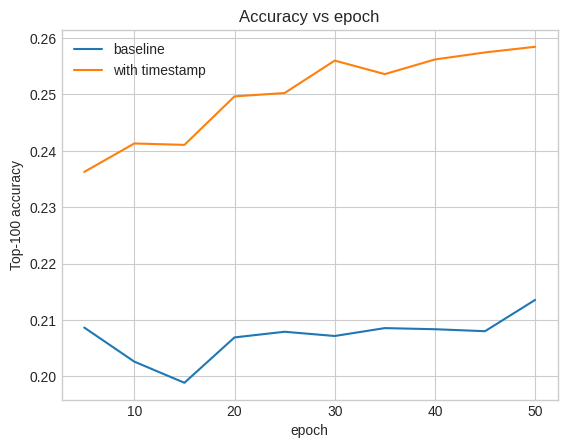

In [14]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, baseline_one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="baseline")
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="with timestamp")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

## Results in Literature

Two-Tower Networks use content-aware features to enhance the collaborative filtering (CF) approaches.

In a study conducted on e-commerce data from e-bay, this approach was shown to have improved results over an existing Recently-Viewed-Item (RVI) method. The existing method recommends items that a user has recently viewed ranked by the viewed item’s recency; RVI is widely used as a way of generating personalized recommendations in production systems. It is also a difficult baseline to beat in terms of generating user engagement, given that these are items the user has engaged with recently. It has also been shown to outperform CF-based
methods.

This method outperformed the RVI method in several Recall@k metrics that were
measured. This shows that the model is able to generate appropriate personalized recommendations based on the user’s current shopping mission, and potentially inspire new ones given the right user history.

In an online evaluation, initial A/B test results showed that compared to the current personalized recommendation module in production, the proposed method increases the conversion rate by ∼6% to generate recommendations for 90% of listing page impressions.

Read more about this study [here](https://arxiv.org/pdf/2102.06156.pdf).


For more information about Tensorflow Recommenders, read more [here](https://www.tensorflow.org/recommenders/examples/basic_retrieval) and for more information about Two-Tower Models, read [here](https://research.google/pubs/pub48840/).